<a href="https://colab.research.google.com/github/theKirill/GensimSample/blob/rusvectores/rusvectores_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Русскоязычный классификатор интентов

In [0]:
from gensim.models import KeyedVectors
from keras.layers.core import Dense, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import collections
import nltk
import numpy as np
import codecs
import pandas as pd
import gensim
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Activation
from keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import save_model, load_model
from keras.callbacks import ModelCheckpoint
from nltk.tokenize import RegexpTokenizer
import collections
import gensim.downloader as api
import pymorphy2
import seaborn as sn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
!pip install keras_metrics

In [0]:
import keras_metrics

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Импорт русскоязычной модели word2vec

In [0]:
model = api.load("word2vec-ruscorpora-300")

[==================================================] 100.0% 198.8/198.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Количество слов в словаре - почти 185к

In [0]:
len(model.vocab)

184973

In [0]:
model.most_similar('добавлять_VERB', topn = 1)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('прибавлять_VERB', 0.6648961305618286)]

Импорт размеченных русскоязычных данных

*   https://github.com/Koziev/chatbot/blob/master/data/intents.txt


In [0]:
file_excel = pd.read_excel('drive/My Drive/ForGensim/russian_train.xlsx', sheet_name='russian_train')

In [0]:
file_excel[:4]

,О_Музыке,Прогноз_Погоды,График_Работы,Заказать_Еду,Будильник
0,Оркестр играл Похоронный марш Бетховена,На следующей неделе пойдет снег?,Отделение банка работает в субботу?,Закажи две пиццы,разбуди меня завтра в шесть
1,Возьму барабаны и вступлю в рок-группу,меня интересует вероятность дождя в ближайшие ...,До скольки работает касса?,Как бесплатно заказать еду на дом или по больш...,разбуди меня завтра в шесть часов
2,Для них пелись самые разные песни,мне интересно знать усилится ли ветер после обеда,Во сколько заканчивает работу касса?,как мне заказать кумыс в Москве?,разбуди меня завтра в семь
3,Из зала доносились звуки оркестра,Идет дождь?,До которого часа касса работает?,Плюс можно заказать поесть.,разбуди меня завтра в семь часов


In [0]:
unique_intents = file_excel.columns

In [0]:
unique_intents

Index(['О_Музыке', 'Прогноз_Погоды', 'График_Работы', 'Заказать_Еду',
       'Будильник'],
      dtype='object')

In [0]:
all_texts, all_intents = [], []

for intent in unique_intents:
  for text in file_excel[intent]:
    if pd.isnull(text):
      break
    else:
      all_texts.append(text)
      all_intents.append(intent)

Подготовка данных (разделение на слова, удаление стоп-слов, пунктуации и добавление к словам части речи для корректной работы с моделью word2vec)

In [0]:
pip install pymorphy2

     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 7.1MB 25.5MB/s 


In [0]:
morph = pymorphy2.MorphAnalyzer()#для перевода в нормальную форму

In [0]:
def tokenize(text):
  regex_tokenizer = RegexpTokenizer('[а-яА-ЯЁё]+')
  words = regex_tokenizer.tokenize(text.lower())
  stop_words = set(stopwords.words("russian"))
  without_stop_words = [(morph.parse(w)[0]).normal_form for w in words if w not in stop_words and len(w) > 1]
  output = [add_part_of_speech(word) for word in without_stop_words]
  #print(output)
  return output

In [0]:
def add_part_of_speech(word):
  morph = pymorphy2.MorphAnalyzer()
  p = morph.parse(word)[0]
  word += '_' + str(p.tag.POS)
  return word

In [0]:
sentences = np.array([tokenize(text) for text in all_texts])

In [0]:
sentences[:5]

array([list(['оркестр_NOUN', 'играть_INFN', 'похоронный_ADJF', 'марш_INTJ', 'бетховен_NOUN']),
       list(['взять_INFN', 'барабан_NOUN', 'вступить_INFN', 'рок_NOUN', 'группа_NOUN']),
       list(['петься_INFN', 'самый_ADJF', 'разный_ADJF', 'песнь_NOUN']),
       list(['зал_NOUN', 'доноситься_INFN', 'звук_NOUN', 'оркестр_NOUN']),
       list(['мочь_NOUN', 'посоветовать_INFN', 'хороший_ADJF', 'душерздерать_INFN', 'песнь_NOUN', 'любовь_NOUN', 'хороший_ADJF', 'примитивный_ADJF', 'текст_NOUN', 'красивый_ADJF', 'музыка_NOUN'])],
      dtype=object)

In [0]:
counter = collections.Counter()

In [0]:
#считаем максимальную длину предложений, а также частоту всех слов предложений, считанных из файла 
maxlen = 0
for words in sentences:
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1

In [0]:
vocab_sz = len(counter) + 1 #кол-во различных слов в sentences

Подготовка данных для обучения для основе ruscorpora

In [0]:
# Преобразование номеров классов в названия классов
def transform_from_categorical(prediction, intents):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(intents[prediction[i]])

  return answers

# Преобразование названий классов в матрицу двоичных чисел (нужно для keras)
def transform_to_categorical(intents_for_each, unique_intents):
  intents_to_digit = []

  for intent in intents_for_each:
    intents_to_digit.append(unique_intents.index(intent))

  return to_categorical(intents_to_digit, len(unique_intents))

In [0]:
# Создание единого словаря (слово -> число) для преобразования на основе списка текстов sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [0]:
X = tokenizer.texts_to_sequences(sentences) #заменяем слова каждого предложения на числа

In [0]:
X[:3]

[[113, 63, 352, 353, 206], [354, 355, 356, 36, 31], [207, 51, 143, 12]]

In [0]:
X = pad_sequences(X, maxlen = maxlen) #уравниваем все предложения до размера maxlen

In [0]:
X[:3]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 113,  63, 352, 353, 206],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 354, 355, 356,  36,  31],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 207,  51, 143,  12]], dtype=int32)

In [0]:
y = transform_to_categorical(all_intents, unique_intents.to_list())#заменяем названия интентов на матрицу двоичных чисел

In [0]:
y[511:]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32

In [0]:
# Объединение двух списков
def add_new_data(old, new):
  result = old

  for i in new:
    result.append(i)

  return result

In [0]:
X_train = X[:20]
y_train = y[:20]
X_test = X[20:204]
y_test = y[20:204]

X_train = add_new_data(X_train.tolist(),X[204:225])
y_train = add_new_data(y_train.tolist(),y[204:225])
X_test = add_new_data(X_test.tolist(),X[225:400])
y_test = add_new_data(y_test.tolist(),y[225:400])

X_train = add_new_data(X_train,X[400:415])
y_train = add_new_data(y_train,y[400:415])
X_test = add_new_data(X_test,X[415:460])
y_test = add_new_data(y_test,y[415:460])

X_train = add_new_data(X_train,X[460:475])
y_train = add_new_data(y_train,y[460:475])
X_test = add_new_data(X_test,X[475:512])
y_test = add_new_data(y_test,y[475:512])

X_train = add_new_data(X_train,X[512:532])
y_train = add_new_data(y_train,y[512:532])
X_test = add_new_data(X_test,X[532:])
y_test = add_new_data(y_test,y[532:])

In [0]:
# X_train, X_test, y_train, y_test = \
#     train_test_split(X, y, test_size = 0.91)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(49, 21) (496, 21) (49, 5) (496, 5)


In [0]:
how_much_for_each_class = np.zeros(5)
y_train_list = (np.array(y_train)).tolist()
for i in range(len(y_train)):
  if y_train_list[i].index(1) == 0:
    how_much_for_each_class[0]+=1
  elif y_train_list[i].index(1) == 1:
    how_much_for_each_class[1]+=1
  elif y_train_list[i].index(1) == 2:
    how_much_for_each_class[2]+=1
  elif y_train_list[i].index(1) == 3:
    how_much_for_each_class[3]+=1
  elif y_train_list[i].index(1) == 4:
    how_much_for_each_class[4]+=1

In [0]:
how_much_for_each_class

array([20., 21., 15., 15., 20.])

Создание keras модели

In [0]:
EMBED_SIZE = 300
NUM_FILTERS = 512
NUM_WORDS = 3
BATCH_SIZE = 32
NUM_EPOCHS = 15

In [0]:
embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))#создаём матрицу размером размерность словаря*размерность вектора слова
index = 0
sorted_counter = counter.most_common() #сортируем слова по частоте встречаемости
for word in sorted_counter:#для каждого слова из нашего словаря задаём вектор из model в матрицу
    try:
      embedding_weights[index, :] = model[word[0]] 
      index+=1     
    except KeyError:#если нет слова в словаре model
      index+=1
      pass

In [0]:
COUNT_CLASSES = len(unique_intents)

Будем использовать метрику f1, так как классы несбалансированны

In [0]:
# Создание модели
def get_model(COUNT_CLASSES, embedding_weights):
  model = Sequential()
  model.add(Embedding(vocab_sz, EMBED_SIZE, input_length = maxlen,
                      weights = [embedding_weights],
                      trainable = True))
  model.add(SpatialDropout1D(0.2))
  model.add(Conv1D(filters = NUM_FILTERS, kernel_size = NUM_WORDS,
                  activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(1024))
  model.add(Dropout(0.2))
  model.add(Activation('relu'))
  
  model.add(Dense(COUNT_CLASSES, activation="softmax"))

  model.compile(optimizer = "adam", loss = "categorical_crossentropy",
                metrics = [keras_metrics.categorical_f1_score()])
  
  return model

In [0]:
keras_model = get_model(COUNT_CLASSES, embedding_weights)

In [0]:
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 300)           306300    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 21, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 512)           461312    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
activation_1 (Activation)    (None, 1024)             

Обучение keras модели

In [0]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [0]:
history = keras_model.fit(X_train, y_train, batch_size = BATCH_SIZE,
                    epochs = NUM_EPOCHS,
                    callbacks=[ModelCheckpoint('drive/My Drive/ForGensim/rus_keras_model.h5', save_best_only = True)],
                    validation_split = 0.1)

Train on 81 samples, validate on 10 samples
Epoch 1/15
81/81 [==============================] - 1s 16ms/step - loss: 1.5908 - f1_score: 0.0000e+00 - val_loss: 2.0557 - val_f1_score: 0.0000e+00
Epoch 2/15
81/81 [==============================] - 0s 3ms/step - loss: 1.4577 - f1_score: 0.0000e+00 - val_loss: 2.0109 - val_f1_score: 0.0000e+00
Epoch 3/15
81/81 [==============================] - 0s 3ms/step - loss: 1.2996 - f1_score: 0.0000e+00 - val_loss: 1.8020 - val_f1_score: 0.0000e+00
Epoch 4/15
81/81 [==============================] - 0s 3ms/step - loss: 1.0684 - f1_score: 0.1818 - val_loss: 1.6030 - val_f1_score: 0.0000e+00
Epoch 5/15
81/81 [==============================] - 0s 3ms/step - loss: 0.7942 - f1_score: 0.7097 - val_loss: 1.0959 - val_f1_score: 0.0000e+00
Epoch 6/15
81/81 [==============================] - 0s 3ms/step - loss: 0.4950 - f1_score: 0.8889 - val_loss: 0.6032 - val_f1_score: 0.0000e+00
Epoch 7/15
81/81 [==============================] - 0s 3ms/step - loss: 0.2508 

In [0]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [0]:
score = keras_model.evaluate(X_test, y_test)
print("Test accuracy: {:.3f}".format(score[1]))

454/454 [==============================] - 0s 329us/step
Test accuracy: 0.919


Модель обучилась с точностью ~92%


**Делаем отчёт по предсказанию (по разным метрикам) + строим матрицу ошибок:**

In [0]:
prediction = keras_model.predict_classes(X_test)

In [0]:
prediction[:3]

array([0, 0, 0])

In [0]:
prediction_names = transform_from_categorical(prediction, unique_intents)

In [0]:
prediction_names[:3]

['О_Музыке', 'О_Музыке', 'О_Музыке']

In [0]:
y_test = y_test.tolist()
y_test_names = []

for i in range(len(y_test)):
  y_test_names.append(unique_intents[y_test[i].index(1)])

In [0]:
y_test_names[:3]

['О_Музыке', 'О_Музыке', 'О_Музыке']

In [0]:
from sklearn.metrics import classification_report

In [0]:
print(classification_report(y_test_names, prediction_names))

                precision    recall  f1-score   support

     Будильник       0.29      0.62      0.39        13
 График_Работы       0.97      0.76      0.85        45
  Заказать_Еду       0.91      0.81      0.86        37
      О_Музыке       0.91      0.94      0.92       184
Прогноз_Погоды       0.90      0.86      0.88       175

      accuracy                           0.87       454
     macro avg       0.79      0.80      0.78       454
  weighted avg       0.89      0.87      0.88       454



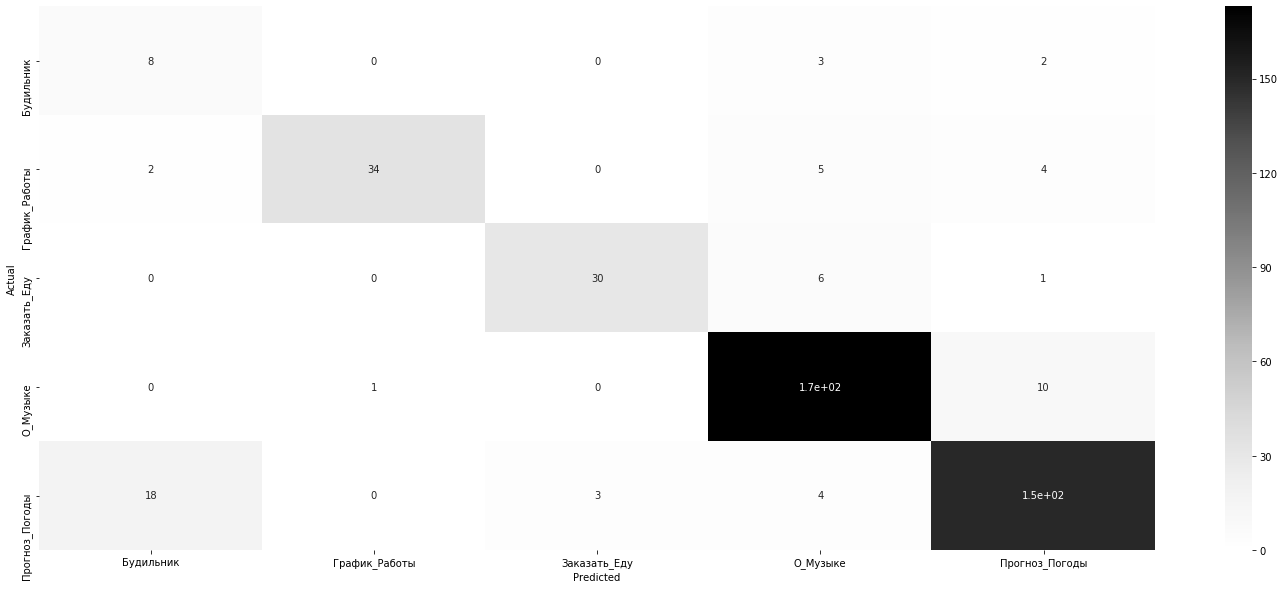

In [0]:
data = {'prediction': prediction_names,
        'actual':    y_test_names
        }

df = pd.DataFrame(data, columns = ['actual','prediction'])
confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames = ['Actual'], colnames = ['Predicted'])
plt.figure(figsize=(25, 10))
sn.heatmap(confusion_matrix, annot=True,cmap="Greys")

**Как видно по матрице ошибок, наша модель чаще всего путает интенты `Прогноз погоды` с `Будильник`, а также `О музыке` с `Прогноз погоды`**

Тестирование (проверка работы) классификатора на небольших данных

In [0]:
test = ['какая погода в Кирове', 'во сколько закрывается аптека', 'я люблю слушать музыку в наушниках', 
        'додо пицца заказать онлайн', 'разбуди меня в семь вечера', 'сегодня было очень холодно', 'сколько песен в моём плеере', 'что сегодня по погоде?'] 

In [0]:
test_sentence = np.array([tokenize(text) for text in test])

In [0]:
sequences_test = tokenizer.texts_to_sequences(test_sentence)
sequences_test

[[1, 141],
 [20, 138],
 [80, 13, 3],
 [87, 4, 351],
 [16, 61, 110],
 [9, 65],
 [20, 11, 732],
 [9, 1]]

In [0]:
X_predict = pad_sequences(sequences_test, maxlen = maxlen)

In [0]:
prediction = keras_model.predict_classes(X_predict)

In [0]:
answers = transform_from_categorical(prediction, unique_intents.to_list()) 
answers

['Прогноз_Погоды',
 'График_Работы',
 'О_Музыке',
 'Заказать_Еду',
 'Будильник',
 'Прогноз_Погоды',
 'О_Музыке',
 'Прогноз_Погоды']